In [21]:
import torch
from PIL import Image
from torchvision import transforms, models
from sys import version
import timm
from tqdm import tqdm
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler as Slearn_Scaler
import seaborn as sns
from functools import reduce
from math import sqrt, floor, ceil, prod
from numpy import linspace
from math import floor, ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
import inspect
import pickle
import pandas as pd
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker

%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')
version

'3.9.5 (default, Apr 15 2022, 15:04:02) \n[GCC 8.4.0]'

In [2]:
from numpy.lib.stride_tricks import sliding_window_view
from math import floor
import multiprocessing
import os
from tqdm.contrib.concurrent import process_map  
from itertools import repeat
    
def get_ifmap_weight_reuse_for_layers_in_model(args):
        model, stats, longest_network_length = args
        model_length = len(stats['raw_stats'])
        idx_list = linspace(0, longest_network_length, model_length)
        model_ifmap_reuse = []
        model_weight_reuse = []
        model_ofmap_reuse = []
        for name, layer in stats['raw_stats'].items():
            if layer.input_size[-1] != layer.input_size[-2]:
                raise Exception("Invalid asymmetric input")
            ifmap_dims = layer.input_size[-2:]
            ifmap_dims = [dim+padding for dim, padding in zip(ifmap_dims, layer.padding)]
            ifmap = np.arange(np.prod(ifmap_dims)).reshape(ifmap_dims)
            stride_x = layer.stride[-1]
            stride_y = layer.stride[-2]
            ifmap_reuse = np.zeros(ifmap_dims)
            views = sliding_window_view(ifmap, layer.kernel_size)[::stride_x, ::stride_y]
            views = views.reshape(-1, *views.shape[-2:])
            for view in views:
                accessed_ifmaps = view.flatten()
                ifmap_y = [floor(pixel/ifmap_dims[0]) for pixel in accessed_ifmaps]
                ifmap_x = [pixel%ifmap_dims[0] for pixel in accessed_ifmaps]
                ifmap_reuse[ifmap_y, ifmap_x] += 1
            avg_ifmap_reuse = np.average(ifmap_reuse)
            filter_count = layer.output_size[0]
            channel_count = layer.input_size[1]
            avg_ifmap_reuse *= (filter_count/ layer.groups)
            avg_ifmap_reuse = avg_ifmap_reuse
            avg_weight_reuse = np.prod(layer.output_size[-2:])
            avg_ofmap_reuse = channel_count / layer.groups
            model_ifmap_reuse.append(avg_ifmap_reuse)
            model_weight_reuse.append(avg_weight_reuse)
            model_ofmap_reuse.append(avg_ofmap_reuse)
        interp_model_ifmap_reuse = np.interp(np.arange(longest_network_length), idx_list, model_ifmap_reuse)
        interp_model_weight_reuse = np.interp(np.arange(longest_network_length), idx_list, model_weight_reuse)
        interp_model_ofmap_reuse = np.interp(np.arange(longest_network_length), idx_list, model_ofmap_reuse)
        return (model, interp_model_ifmap_reuse, interp_model_weight_reuse, interp_model_ofmap_reuse)
    
def get_ifmap_weight_reuse_trends():

    def load_stats_dict():
        with open('../data/stats_dict.backup', 'rb') as backup:
            stats_dict = pickle.load(backup)
        return stats_dict
    stats_dict = load_stats_dict()
    
    longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
    
    models_stats_dict_without_ssd = {m:s for m, s in stats_dict.items() if m!='ssd'}
    
    args = list(zip(models_stats_dict_without_ssd.keys(), models_stats_dict_without_ssd.values(), repeat(longest_network_length)))
    
    r = process_map(get_ifmap_weight_reuse_for_layers_in_model, args, max_workers=32)

    longest_network_length = max([len(stats['raw_stats'].keys()) for model, stats in stats_dict.items()])
    models_stats_dict_without_ssd = {m:s for m, s in stats_dict.items() if m!='ssd'}

    ifmap_reuse = np.array([a[1] for a in r]).reshape(-1, 1)
    weight_reuse = np.array([a[2] for a in r]).reshape(-1, 1)
    ofmap_reuse = np.array([a[3] for a in r]).reshape(-1, 1)
    idxs = np.tile(np.arange(longest_network_length), len(models_stats_dict_without_ssd.keys()))
    idxs = np.array([i/longest_network_length*100 for i in idxs])

    df = pd.DataFrame({'idxs': idxs.squeeze(), 'ifmap_reuse': ifmap_reuse.squeeze(), 'weight_reuse': weight_reuse.squeeze(), 'ofmap_reuse': ofmap_reuse.squeeze()})
    
    return df 
    
df = get_ifmap_weight_reuse_trends()

  0%|          | 0/418 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ifmap/Ofmap/Weight Reuse Trend Per Element Loaded On Chip')

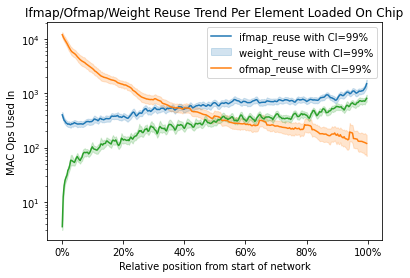

In [16]:

sns.lineplot(
    data=df, x="idxs", y="ifmap_reuse", ci=99
)
sns.lineplot(
    data=df, x="idxs", y="weight_reuse", ci=99
)
se_plt = sns.lineplot(
    data=df, x="idxs", y="ofmap_reuse", ci=99
)
se_plt.legend(['ifmap_reuse with CI=99%', 'weight_reuse with CI=99%', 'ofmap_reuse with CI=99%'])

se_plt.xaxis.set_major_formatter(PercentFormatter())
plt.xlabel('Relative position from start of network')
plt.yscale('log', base = 10)
plt.ylabel('MAC Ops Used In')
plt.title('Ifmap/Ofmap/Weight Reuse Trend Per Element Loaded On Chip')


In [6]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_prop_dict = layer_properties.to_dict(orient="index")

ifmap_mem_sizes = {}
for (model_name, layer_name), properties in layer_prop_dict.items():
    ifmap_mem_size = properties["ifmap_mem_size"]
    try:
        ifmap_mem_sizes[model_name].append(ifmap_mem_size)
    except KeyError as e:
        ifmap_mem_sizes[model_name] = [ifmap_mem_size]
ofmap_mem_sizes = {}
for (model_name, layer_name), properties in layer_prop_dict.items():
    ofmap_mem_size = properties["ofmap_mem_size"]
    try:
        ofmap_mem_sizes[model_name].append(ofmap_mem_size)
    except KeyError as e:
        ofmap_mem_sizes[model_name] = [ofmap_mem_size]
longest_network_length = max([len(values) for _, values in ifmap_mem_sizes.items()])
interp_ifmap_sizes = {}
for model_name, values in ifmap_mem_sizes.items():
    model_length = len(values)
    idx_list = np.linspace(0, longest_network_length, model_length)
    interp_ifmap_sizes[model_name] = np.interp(
        np.arange(longest_network_length), idx_list, values
    )
interp_ofmap_sizes = {}
for model_name, values in ofmap_mem_sizes.items():
    model_length = len(values)
    idx_list = np.linspace(0, longest_network_length, model_length)
    interp_ofmap_sizes[model_name] = np.interp(
        np.arange(longest_network_length), idx_list, values
    )
interp_sizes = {
    model_name: {
        "ifmap_mem": interp_ifmap_sizes[model_name],
        "ofmap_mem": interp_ofmap_sizes[model_name],
    }
    for model_name in interp_ifmap_sizes.keys()
}
interp_sizes_as_records = []
for model_name, sizes in interp_sizes.items():
    for idx, (ifmap_size, ofmap_size) in enumerate(
        zip(sizes["ifmap_mem"], sizes["ofmap_mem"])
    ):
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "ifmap_size": ifmap_size,
                "ofmap_size": ofmap_size,
            }
        )
df = pd.DataFrame.from_records(interp_sizes_as_records)

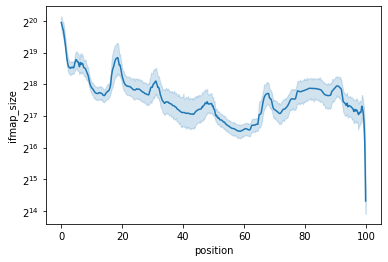

In [11]:
plt = sns.lineplot(
    data=df, x="position", y="ifmap_size", ci=99
)
plt.set_yscale('log', base = 2)


<AxesSubplot:>

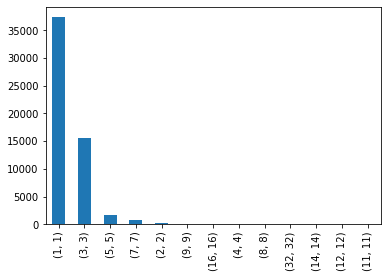

In [141]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
freq = layer_properties['kernel_size'].value_counts()
freq.plot(kind='bar')

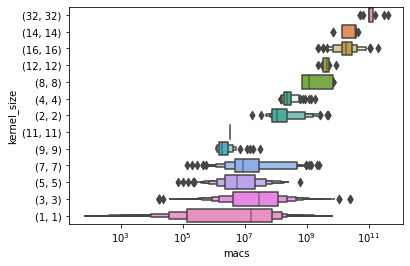

In [133]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
macs_vs_ksize = layer_properties[["macs", "kernel_size"]]
plt = sns.boxenplot(
    data=macs_vs_ksize,
    y="kernel_size",
    x="macs",
    order=macs_vs_ksize.groupby("kernel_size").min().sort_values(by="macs", ascending=False).index,
)
plt.set_xscale('log', base=10)


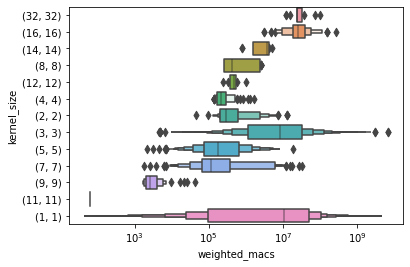

In [140]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
macs_vs_ksize = layer_properties[["macs", "kernel_size"]]
freq = layer_properties["kernel_size"].value_counts()
macs_vs_ksize = macs_vs_ksize.assign(kernel_multipler=1)
for idx in freq.index:
    filtered_df = macs_vs_ksize[macs_vs_ksize["kernel_size"] == idx]
    macs_vs_ksize.loc[
        macs_vs_ksize.index.isin(filtered_df.index), "kernel_multipler"
    ] = freq[idx]
macs_vs_ksize["weighted_macs"] = (
    macs_vs_ksize["macs"] * macs_vs_ksize["kernel_multipler"] / np.sum(freq.values)
)
plt = sns.boxenplot(
    data=macs_vs_ksize,
    y="kernel_size",
    x="weighted_macs",
    order=macs_vs_ksize.groupby("kernel_size").min().sort_values(by="weighted_macs", ascending=False).index,
)
plt.set_xscale('log', base=10)